In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bookcrossing-dataset/Users.csv
/kaggle/input/bookcrossing-dataset/Books.csv
/kaggle/input/bookcrossing-dataset/Ratings.csv
/kaggle/input/booksdata/BX-Users.csv
/kaggle/input/booksdata/BX-Book-Ratings.csv
/kaggle/input/booksdata/BX-Books.csv


### About Book Crossing Dataset

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0

Link to dataset files
http://www2.informatik.uni-freiburg.de/~cziegler/BX/

## About this Project

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches

In [2]:
#Making necesarry imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [4]:
#Loading data
books = pd.read_csv('../input/booksdata/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('../input/booksdata/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('../input/booksdata/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [5]:
#checking shapes of the datasets
print (books.shape)
print (users.shape)
print (ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


As we can see 

In [6]:
display(books.head())

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


We can drop the unused columns from the books dataframe which is (imageUrlS, imageUrlM, imageUrlL), we won't use them

In [7]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis = 1, inplace=True)

In [8]:
display(books.head())

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


## 1. Books table
### 1.1 Data cleaning

In [9]:
# check types 
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

### 1.1.a yearOfPublication column

In [10]:
# change yearOfPublication into int
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Have a string of 'DK Publishing Inc' in the year of publication, need to investigate this 


In [11]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [12]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [13]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [14]:
#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [15]:
pd.set_option('display.max_colwidth', -1)

In [16]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [17]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [18]:
#rechecking
books.loc[(books.ISBN == '2070426769'),:]
#corrections done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [19]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [20]:
print (books['yearOfPublication'].unique())
#Now it can be seen that yearOfPublication has all values as integers

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984
    0 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973
 1972 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950
 1967 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947
 1945 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927
 1931 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917
 1901 2010 1908 1906 1935 1806 2021 2012 2006 1909 2008 1378 1919 1922
 1897 2024 1376 2037]


As resulted from the above value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be invalid keeping some margin in case dataset was updated thereafer setting invalid years as NaN

In [21]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [22]:
#replacing NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [23]:
#rechecking
books.yearOfPublication.isnull().sum()
#No NaNs

0

In [24]:
#resetting the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

### 1.1.b publisher column

In [25]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


We have 2 Nas needs processing. I will investigate if those two observations have a clue in other incidents.

In [26]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


In [27]:
# do the same for the other book title
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


In [28]:
# search by book author to find any patterns
books.loc[(books.bookAuthor == 'Elaine Corvidae'), :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory


In [29]:
books.loc[(books.bookAuthor == 'Linnea Sinclair'), :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [30]:
#since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

## 2 Users table


In [31]:
users.shape
display(users.head())

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [32]:
users.dtypes

userID      int64  
Location    object 
Age         float64
dtype: object

### 2.1 Data cleaning

### 2.1.a userId column

In [33]:
users.userID.values

array([     1,      2,      3, ..., 278856, 278857, 278858])

### 2.1.b Age column

In [34]:
print (sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

userID has invalid values like nan!!, 140!!!, 189!!!, 223!!!

Steps to handle those non-logical values are: 

1. Replace the non-logic values with `np.NaN` for values greater than 5 and less than 90.

2. Replace NaN value with the mean

3. Setting the column type into int32.

4. Reshaping the column

In [35]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In [36]:
#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

In [37]:
#setting the data type as int
users.Age = users.Age.astype(np.int32)

In [38]:
#rechecking
print (sorted(users.Age.unique()))


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## 3. Ratings table

In [39]:
print(ratings.shape)
display(ratings.head())

(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [40]:
#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print (n_users * n_books)

75670906880


In [41]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [42]:
#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [43]:
print (ratings.shape)
print (ratings_new.shape)


(1149780, 3)
(1031136, 3)


It can be seen that many rows having book ISBN not part of books dataset got dropped off

In [44]:
#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings = ratings[ratings.userID.isin(users.userID)]

In [45]:
print (ratings.shape)
print (ratings_new.shape)
#no new users added, hence we will go with above dataset ratings_new (1031136, 3)

(1149780, 3)
(1031136, 3)


In [46]:

print ("number of users: " + str(n_users))
print ("number of books: " + str(n_books))

number of users: 278858
number of books: 271360


In [47]:
#Sparsity of dataset in %

sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print ('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 99.99863734155898 %


In [48]:
#As quoted in the description of the dataset -
#BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 
#higher values denoting higher appreciation, or implicit, expressed by 0
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [49]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [50]:
#checking shapes
print (ratings_new.shape)
print (ratings_explicit.shape)
print (ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


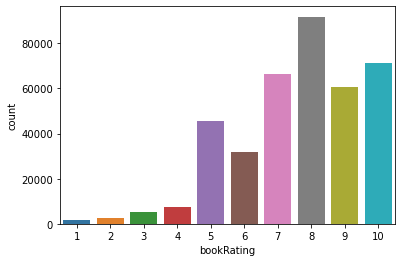

In [51]:
#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()


It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

## Popularity model

At this point , a simple popularity based recommendation system can be built based on count of user ratings for different books

In [52]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print ("Following books are recommended")
top10.merge(books, left_index = True, right_on = 'ISBN')

Following books are recommended


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [53]:
display(ratings_explicit.head())

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [54]:
!pip install pyspark

     |████████████████████████████████| 204.7 MB 19 kB/s s eta 0:00:01   |██▋                             | 16.8 MB 3.5 MB/s eta 0:00:55
     |████████████████████████████████| 198 kB 63.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=8e3e3bdbe2d93020adcf4443bc7677b5429348a1093b31e875b89022c32c2879
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [55]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator


In [56]:
# convert into spark dataframe
# spark.conf.set("spark.sql.excution.arrow.enabled", "true")

spark = SparkSession.builder.appName('bookRecommender').getOrCreate()



In [83]:
mySchema = StructType([ StructField("userID", IntegerType(), True)\
                        ,StructField("ISBN", StringType(), True)\
                        ,StructField("bookRating", IntegerType(), True)])

In [84]:
df_1 = spark.createDataFrame(ratings_explicit, schema=mySchema)

In [85]:
type(df_1)

pyspark.sql.dataframe.DataFrame

In [86]:
sp_ratings_df = df_1.cache()

In [87]:
display(sp_ratings_df.show(10))

+------+----------+----------+
|userID|      ISBN|bookRating|
+------+----------+----------+
|276726|0155061224|         5|
|276729|052165615X|         3|
|276729|0521795028|         6|
|276744|038550120X|         7|
|276747|0060517794|         9|
|276747|0671537458|         9|
|276747|0679776818|         8|
|276747|0943066433|         7|
|276747|1885408226|         7|
|276748|0747558167|         6|
+------+----------+----------+
only showing top 10 rows



None

## Converting String to index
Before making an ALS model it needs to be clear that ALS only accepts integer value as parameters. Hence we need to convert asin and reviewerID column in index form.

In [93]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

indexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_Index").fit(sp_ratings_df)
transformed = indexer.transform(sp_ratings_df)


In [94]:
display(transformed.show(3))

+------+----------+----------+----------+
|userID|      ISBN|bookRating|ISBN_Index|
+------+----------+----------+----------+
|276726|0155061224|         5|   58420.0|
|276729|052165615X|         3|   87191.0|
|276729|0521795028|         6|   87208.0|
+------+----------+----------+----------+
only showing top 3 rows



None

In [95]:
transformed = transformed.withColumn("ISBN_Index", transformed["ISBN_Index"].cast(IntegerType()))

In [96]:

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["bookRating"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    transformed = pipeline.fit(transformed).transform(transformed).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
transformed.show(5)

After Scaling :
+------+----------+----------+----------+-----------------+
|userID|      ISBN|bookRating|ISBN_Index|bookRating_Scaled|
+------+----------+----------+----------+-----------------+
|276726|0155061224|         5|     58420|            0.444|
|276729|052165615X|         3|     87191|            0.222|
|276729|0521795028|         6|     87208|            0.556|
|276744|038550120X|         7|       216|            0.667|
|276747|0060517794|         9|      1070|            0.889|
+------+----------+----------+----------+-----------------+
only showing top 5 rows



In [97]:
display(transformed.show(3))

+------+----------+----------+----------+-----------------+
|userID|      ISBN|bookRating|ISBN_Index|bookRating_Scaled|
+------+----------+----------+----------+-----------------+
|276726|0155061224|         5|     58420|            0.444|
|276729|052165615X|         3|     87191|            0.222|
|276729|0521795028|         6|     87208|            0.556|
+------+----------+----------+----------+-----------------+
only showing top 3 rows



None

In [98]:
transformed.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- bookRating: integer (nullable = true)
 |-- ISBN_Index: integer (nullable = true)
 |-- bookRating_Scaled: double (nullable = true)



In [99]:
(training, test) = transformed.randomSplit([0.8, 0.2])

In [100]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, 
          userCol="userID", itemCol="ISBN_Index", ratingCol="bookRating_Scaled",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="bookRating_Scaled",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.7616793765174756


In [101]:
display(predictions.show(10))

+------+----------+----------+----------+-----------------+------------+
|userID|      ISBN|bookRating|ISBN_Index|bookRating_Scaled|  prediction|
+------+----------+----------+----------+-----------------+------------+
|264284|0060977493|         3|       148|            0.222| 0.021470953|
| 28177|0060977493|         5|       148|            0.444|  0.08243139|
|243879|0060977493|        10|       148|              1.0|  0.04786245|
| 81977|0060977493|        10|       148|              1.0|  0.04513248|
|239393|0060977493|         5|       148|            0.444|9.4368577E-4|
|138198|0060977493|         7|       148|            0.667| 0.017263982|
|228351|0060977493|         7|       148|            0.667|0.0060762637|
|215375|0060977493|         8|       148|            0.778|-0.009745508|
| 98154|0060977493|        10|       148|              1.0|0.0033345332|
|278218|0060977493|         7|       148|            0.667| 4.289125E-4|
+------+----------+----------+----------+----------

None

In [ ]:
user_recs=model.recommendForAllUsers(10).show(10)

## Collaborative Filtering Based model

## Training model

## User-Based recommender model

## Item-based recommender system